In [32]:


import os

import matplotlib.pyplot as plt
import pandas as pd
# import seaborn as sns
import numpy as np
from sklearn.manifold import TSNE
import pickle
import torchvision
import torch
import cv2
import numpy as np
import scipy.misc

In [16]:
def load_files(path):
    df = pd.read_csv(path+'clustering_results.csv')
    
    domain = df['predictions'].values
    
    vec_d = df['vec_d_labels'].values
    vec_y = df['vec_y_labels'].values
    img_locs = df['image_id_labels'].values

    Z = np.load(path + "Z_space.npy")
    model_name = path.split('_')[-1]

    #args = np.loadtxt(path + "arguments.txt", dtype=str, usecols=0)  # , delimiter = '\n')
    #img_locs = np.loadtxt(path + "img_id.txt", dtype=str)
    with open(os.path.join(path, 'commandline_arguments.p'), 'rb') as file:
        command_line = pickle.load(file)
    
    return domain, vec_d, vec_y, img_locs, model_name, df, command_line

In [17]:
ex = '2023-10-15 16:52:23.823748_weah_sdcn/'

In [18]:
domain, vec_d, vec_y, img_locs, model_name, results_df, command_line = load_files(ex)
print(command_line)

Namespace(config_file=None, lr=0.0001, gamma_reg=0.1, es=10, seed=0, nocu=False, device=None, gen=False, keep_model=False, epos=5, epo_te=1, debug=False, dmem=False, no_dump=False, trainer=None, out='zoutput', dpath='../../WashU_with_coord/combined_training_with_coords/', tpath=None, npath=None, npath_dom=None, npath_argna2val=None, nname_argna2val=None, nname=None, nname_dom=None, apath='domid/algos/builder_sdcn.py', exptag='exptag', aggtag='aggtag', bm_dir=None, msel=None, aname='sdcn', acon=None, task='weah', bs=2700, split=0, te_d=['0'], tr_d=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64'], san_check=False, san_num=8, zd_dim=500, zx_dim=0, zy_dim=64, topi

In [19]:
def subject_info(img_locs,subjects,domain, N):
    '''
    Gets all the information for one subject
    '''
    sub_img = []
    sub_domain = []

    for i, (img) in enumerate(img_locs):
        if subjects[N] in img:
            sub_img.append(img)
            sub_domain.append(domain[i])
    patch_x = [int(img.split('/')[-1].split('_')[-6]) for img in sub_img]
    patch_y = [int(img.split('/')[-1].split('_')[-5]) for img in sub_img]

    x_coords = [int(img.split('/')[-1].split('_')[-2][2:]) for img in sub_img]
    y_coords = [int(img.split('/')[-1].split('_')[-1].split('.')[0]) for img in sub_img]
    return sub_img,sub_domain, patch_x, patch_y, x_coords, y_coords

In [23]:

def get_mask(domain):
    '''
    outputs colored mask for one patch based on the predicted domain of the patch
    (is not currently used)
    '''
    mask = torch.zeros(3, 256, 256, dtype=torch.uint8)
    if domain == 1:
        # Pink mask
        mask[0, :, :] = 255  # Set the red channel to 255
        mask[2, :, :] = 255  # Set the blue channel to 255
    elif domain == 2:
        # Orange mask
        mask[0, :, :] = 255  # Set the red channel to 255
        mask[1, :, :] = 128  # Set the green channel to 128 for orange color
    elif domain == 3:
        # Yellow mask
        mask[0, :, :] = 255  # Set the red channel to 255
        mask[1, :, :] = 255  # Set the green channel to 255
    elif domain == 4:
        # Green mask
        mask[1, :, :] = 255  # Set the green channel to 255
    elif domain == 5:
        # Blue mask
        mask[2, :, :] = 255  # Set the blue channel to 255
    elif domain == 6:
        # Red mask
        mask[0, :, :] = 255  # Set the red channel
    return mask

In [24]:
import torchvision.transforms as transforms
def combined_img_mask(sub_img, sub_domain, x_coords, y_coords):
    '''
    creates a canvas for one region for one subject 
    created mask canvas for one region for one subjects based majority voting for every single pixel in the region
    transforms all the patches into grey scale images
    
    '''
    n_x = max(x_coords)//256+2
    n_y = max(y_coords)//256+2


    combined_image = torch.zeros((3, n_x*256, n_y*256), dtype=torch.uint8)
    combined_mask = torch.empty((len(sub_img), n_x*256, n_y*256, 6), dtype=torch.uint8)
    counter=0
    transform = transforms.Grayscale()
    # Iterate through the image patches and their locations
    for p, x, y in zip(sub_img, x_coords, y_coords):
        img = torchvision.io.read_image(os.path.join('../',p))
        #img = transform(img)
        _, h, w, = img.shape  


        combined_image[:, x:x+w, y:y+h] =img
        mask = torch.zeros((1, 256, 256, 6),dtype=torch.uint8)
        mask[:, :, :, sub_domain[counter]-1] += torch.ones((1, 256, 256), dtype=torch.uint8)
        combined_mask[counter, x:x+w, y:y+h, :] = mask

        counter+=1
        if counter>300:
            break
    #majority vting
    
    
    #combined_mask, _ = torch.sort(combined_mask, dim=0, descending=True)
    #majority_voted_mask, _ = torch.mode(combined_mask[:3], dim=0)
    print(combined_mask.shape)
    M = torch.sum(combined_mask.detach().cpu(), dim=0)
    majority_voted_mask = torch.argmax(M, dim=2)
 
        
        
    
    return combined_image, majority_voted_mask
 


In [34]:
def plot_mask_from_1d_mask(oneD_mask):
    '''
    converts one 1 majority voting mask to 3 channel mask 
    '''

    color_palette = {
        0: [0, 0, 0],
        1: [255, 0, 0],    # Red
        2: [0, 255, 0],    # Green
        3: [0, 0, 255],    # Blue
        4: [255, 255, 0],  # Yellow
        5: [128, 0, 128],  # Purple
        6: [255, 165, 0]   # Orange
    }

    rows, cols = oneD_mask.shape
    output_tensor = np.zeros((rows, cols, 3), dtype=np.uint8)
    for i in range(rows):
        for j in range(cols):
            element = oneD_mask[i, j].item()
            output_tensor[i, j, :] = color_palette[element]
    return output_tensor


    

In [35]:
subjects = list(set([l.split('/')[4] for l in img_locs]))
print(subjects)
N=7
print(subjects[N])
sub_img,sub_domain, patch_x, patch_y, x_coords, y_coords = subject_info(img_locs,subjects,domain, N)

['APERIO-005-0', 'APERIO-123-0', 'APERIO-029-0', 'APERIO-101-0', 'APERIO-127-0', 'APERIO-126-0', 'APERIO-059-0', 'APERIO-075-0', 'APERIO-136-0', 'APERIO-027-0', 'APERIO-113-0', 'APERIO-107-0', 'APERIO-062-0', 'APERIO-106-0', 'APERIO-048-0', 'APERIO-060-0', 'APERIO-009-0', 'APERIO-098-0', 'APERIO-063-0', 'APERIO-080-0', 'APERIO-100-0', 'APERIO-037-0', 'APERIO-138-0', 'APERIO-085-0', 'APERIO-077-0', 'APERIO-120-0', 'APERIO-114-0', 'APERIO-011-0', 'APERIO-030-0', 'APERIO-086-0', 'APERIO-069-0', 'APERIO-071-0', 'APERIO-118-0', 'APERIO-092-0', 'APERIO-016-0', 'APERIO-007-0', 'APERIO-049-0', 'APERIO-015-0', 'APERIO-119-0', 'APERIO-054-0', 'APERIO-065-0', 'APERIO-117-0', 'APERIO-076-0', 'APERIO-139-0', 'APERIO-115-0', 'APERIO-021-0', 'APERIO-010-0', 'APERIO-033-0', 'APERIO-082-0', 'APERIO-035-0', 'APERIO-133-0', 'APERIO-056-0', 'APERIO-008-0', 'APERIO-064-0', 'APERIO-087-0', 'APERIO-108-0', 'APERIO-084-0', 'APERIO-047-0', 'APERIO-096-0', 'APERIO-137-0', 'APERIO-091-0', 'APERIO-023-0', 'APERIO

In [36]:
combined_image, majority_voted_mask = combined_img_mask(sub_img[:299], sub_domain[:299], x_coords[:299], y_coords[:299])

torch.Size([299, 6144, 6400, 6])


In [38]:
twoD_mask = plot_mask_from_1d_mask(majority_voted_mask)

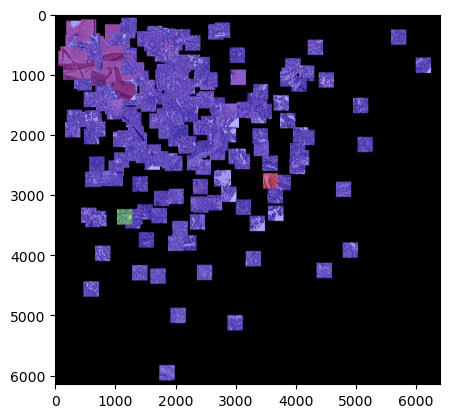

In [39]:
img = cv2.imwrite('color_img.jpg', combined_image.permute(1,2,0).numpy())
img = cv2.imread('color_img.jpg')
mask_image = twoD_mask 
alpha = 0.3
masked_image_ = cv2.addWeighted(mask_image, alpha, img, 1-alpha, 0)
plt.imshow(masked_image_)

aperio-075-0


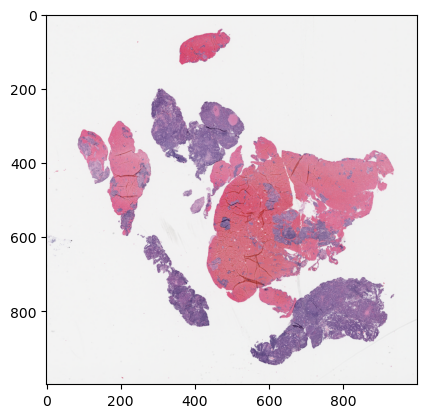

In [37]:
import slideio
path = '../../../../../gpfs_projects/wxc4/DigiPath-WashU-Data/Washu-Aperio'
subject = subjects[N].lower()
print(subject)
sample_wsi = os.path.join(path, subject)
slide = slideio.open_slide(sample_wsi+'.svs', "SVS")
scene = slide.get_scene(0)
image = scene.read_block(size=(1000,0))
plt.imshow(image)
plt.show()

In [42]:
def plot_one_sub(sub_img,sub_domain, patch_x, patch_y, x_coords, y_coords, plotting=True):
    '''
    plots all the regions for one subjects
    creates a canvas and maks for WSI 
    
    '''
    patch_x =np.array(patch_x)-min(patch_x)
    patch_y =np.array(patch_y)-min(patch_y)
    X= max(patch_x)-min(patch_x)
    Y = max(patch_y)-min(patch_y)

    WSI_img = torch.zeros((3, 2*X, 2*Y),  dtype=torch.uint8)
    WSI_mask =torch.zeros((2*X, 2*Y, 3), dtype=torch.uint8)
    print('canvas shape', WSI_img.shape)
    for patch_num in range(0, 3):
        
        start = patch_num*300
        end=start+300
        print('regions number', patch_num, start, end)

        combined_image, majority_voted_mask = combined_img_mask(sub_img[start:end],sub_domain[start:end], x_coords[start:end], y_coords[start:end])
        print('done')
        twoD_mask = plot_mask_from_1d_mask(majority_voted_mask)
        print('done')
        c, h, w = combined_image.shape 
        WSI_img[:,patch_x[start]:patch_x[start]+h,patch_y[start]:patch_y[start]+w]=combined_image
        WSI_mask[patch_x[start]:patch_x[start]+h,patch_y[start]:patch_y[start]+w, :]=torch.from_numpy(twoD_mask)
        print('done')
        if plotting:
            plot_masked_img(combined_image, twoD_mask, 'Subject='+subjects[N]+'  patches: '+str(start)+'-'+str(end))
        start = end
    return WSI_img, WSI_mask
    


In [ ]:
sub_img,sub_domain, patch_x, patch_y, x_coords, y_coords = subject_info(img_locs,subjects,domain, 7)
print(len(patch_x), len(x_coords))
WSI_img, WSI_mask = plot_one_sub(sub_img,sub_domain, patch_x, patch_y, x_coords, y_coords, plotting=True)

900 900
canvas shape torch.Size([3, 39764, 43254])
regions number 0 0 300
torch.Size([300, 6144, 6400, 6])


In [ ]:
copy_wsi_mask = WSI_mask

In [ ]:
import torch.nn.functional as F

print(copy_wsi_mask.shape)
print(image.shape)

# Rescale the tensor
output_tensor = copy_wsi_mask[::100, ::100, :]
output_tensor = output_tensor[:1000, :1000, :]
print(output_tensor.shape)

In [ ]:
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(output_tensor)
plt.show()